In [1]:
import glob
import random

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
from torchvision.transforms import v2 as transforms

import lightning as pl
from lightning.pytorch.callbacks.model_summary import summarize
from lightning.pytorch.callbacks import ModelCheckpoint

from datasets import BinaryKeyboardSegmentationDataset

In [2]:
device = "cpu"

if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"

In [3]:
def normalize(_img):
    _img -= _img.min()
    _img /= _img.max()
    return _img

def _imshow(im, a, **kwargs):
    if isinstance(im, np.ndarray):
        im = normalize(im.astype("float"))
    if isinstance(im, torch.Tensor):
        im = normalize(im.float())
        
    if len(im.shape) == 3 and im.shape[-1] not in {1, 3, 4}:
        im = im.permute(1, 2, 0)

    a.axis("off")
    a.imshow(im, interpolation="nearest", **kwargs)


def imshow(im, _mask=None, **kwargs):
    if _mask is None:
        plt.figure()
        return _imshow(im, plt.gca())

    if isinstance(im, torch.Tensor) and im.device != "cpu":
        im = im.cpu()
    if isinstance(_mask, torch.Tensor) and _mask.device != "cpu":
        _mask = _mask.cpu()

    _, (ax1, ax2) = plt.subplots(ncols=2)    
    _imshow(im, ax1, **kwargs)
    _imshow(_mask, ax2, **kwargs)

In [4]:
DATASET_VERSION = 1

image_paths = glob.glob(f"assets/keyboards_v{DATASET_VERSION}/**")
random.shuffle(image_paths)

In [5]:
mean = np.array([0.24688599, 0.26204664, 0.27277607])
std = np.array([0.23467262, 0.23974325, 0.25180832])

In [6]:
val_size = int(len(image_paths) * 0.16)
train_size = int(len(image_paths) * 0.8)

valid_paths = image_paths[:val_size]
train_paths = image_paths[val_size:train_size]
test_paths = image_paths[train_size:]

train_dataset = BinaryKeyboardSegmentationDataset(train_paths, size=(256, 320))
valid_dataset = BinaryKeyboardSegmentationDataset(valid_paths, size=(256, 320))
test_dataset = BinaryKeyboardSegmentationDataset(test_paths, size=(256, 320))

len(train_dataset), len(valid_dataset), len(test_dataset)

  0%|          | 0/640 [00:00<?, ?it/s]

  0%|          | 0/640 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/160 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

(640, 160, 200)

In [7]:
train_dataset.set_transforms([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    # transforms.RandomAffine(degrees=30, shear=30, translate=(0.25, 0.25)),
    # transforms.RandomPerspective(distortion_scale=0.25, p=0.5),
    transforms.RandomErasing(p=0.5),
])

train_dataset.set_augmentations([
    transforms.RandomChannelPermutation(),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.GaussianNoise(sigma=0.01),
    transforms.RandomApply([transforms.GaussianNoise(sigma=0.01)], p=0.5),
    transforms.RandomApply([transforms.GaussianNoise(sigma=0.02)], p=0.5),
    transforms.Normalize(mean, std),
])

In [8]:
dl_kwargs = {"batch_size": 32, "num_workers": 2, "persistent_workers": True, "pin_memory": True}

train_dataloader = DataLoader(train_dataset, **dl_kwargs, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, **dl_kwargs)
test_dataloader = DataLoader(test_dataset, **dl_kwargs)

302 (3, 256, 320)


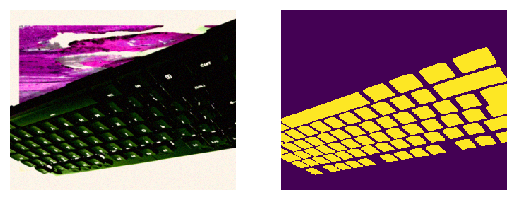

In [9]:
i = random.randint(0, len(train_dataset) - 1)
img, mask = train_dataset[i]

print(i, tuple(img.shape))
imshow(img, mask)

In [10]:
import segmentation_models_pytorch as smp


class BinarySegmentationModel(pl.LightningModule):
    def __init__(self, arch, encoder_name, in_channels, out_classes, **kwargs):
        super().__init__()
    
        self.model = smp.create_model(arch, encoder_name, in_channels=in_channels, classes=out_classes, **kwargs)
        self.loss_fn = smp.losses.DiceLoss(smp.losses.BINARY_MODE, from_logits=True)
        
        self.lr = LEARNING_RATE
        self.save_hyperparameters()

    def forward(self, image):
        return self.model(image)

    def _step(self, batch, stage):
        if trainer.global_step == 0:
            wandb.define_metric(f"{stage}_loss", summary="min")
            
        image, truth = batch
        prediction = self.forward(image)

        loss = self.loss_fn(prediction, truth)
        self.log(f"{stage}_loss", loss)
        return loss

        # prob_mask = logits_mask.sigmoid()
        # pred_mask = (prob_mask > 0.5).float()

        # True/False positives/negatives
        # tp, fp, fn, tn = smp.metrics.get_stats(pred_mask.long(), mask.long(), mode="binary")
        # return {"loss": loss, "tp": tp, "fp": fp, "fn": fn, "tn": tn}

    def training_step(self, batch, batch_idx):
        return self._step(batch, "train")

    def validation_step(self, batch, batch_idx):
        return self._step(batch, "val")

    def test_step(self, batch, batch_idx):
        return self._step(batch, "test")

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=LEARNING_RATE)
        # scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=STEPS, eta_min=1e-5)
        return {"optimizer": optimizer} # "lr_scheduler": {"scheduler": scheduler, "interval": "step", "frequency": 1}

In [11]:
import wandb
from lightning.pytorch.loggers import WandbLogger

wandb.login()

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: bhavye-mathur. Use `wandb login --relogin` to force relogin


True

In [12]:
ARCH = "Unet"
BACKBONE = "resnet18"

EPOCHS = 100
LEARNING_RATE = 1e-4

PROFILE = False

STEPS = EPOCHS * len(train_dataloader)

wandb.finish()
model = BinarySegmentationModel(ARCH, BACKBONE, in_channels=3, out_classes=1)
model

BinarySegmentationModel(
  (model): Unet(
    (encoder): ResNetEncoder(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (1): BasicBlock(
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        

In [112]:
summarize(model)

  | Name    | Type     | Params | Mode 
---------------------------------------------
0 | model   | Unet     | 14.3 M | train
1 | loss_fn | DiceLoss | 0      | train
---------------------------------------------
14.3 M    Trainable params
0         Non-trainable params
14.3 M    Total params
57.313    Total estimated model params size (MB)
141       Modules in train mode
0         Modules in eval mode

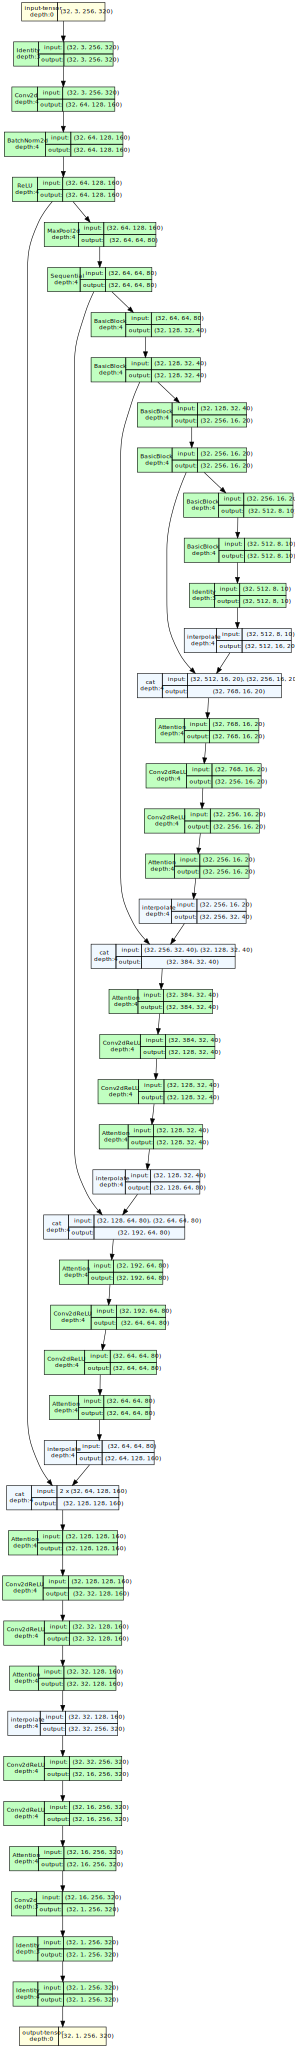

In [138]:
from torchview import draw_graph

model_graph = draw_graph(model, input_size=(32, *img.shape), device="meta", depth=4)
model_graph.visual_graph

In [140]:
model.to_empty(device=device)

logger = WandbLogger(project="mrover-keyboard-region-segmentation")
logger.experiment.config["dataset"] = DATASET_VERSION
# logger.watch(model, log="all", log_freq=len(train_dataloader))

checkpoint_callback = ModelCheckpoint(monitor="val_loss", mode="min")

profiler = "advanced" if PROFILE else None
trainer = pl.Trainer(max_epochs=EPOCHS, log_every_n_steps=1, logger=logger, callbacks=[checkpoint_callback], profiler=profiler)
trainer.fit(model, train_dataloaders=train_dataloader, val_dataloaders=valid_dataloader)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name    | Type     | Params | Mode 
---------------------------------------------
0 | model   | Unet     | 14.3 M | train
1 | loss_fn | DiceLoss | 0      | train
---------------------------------------------
14.3 M    Trainable params
0         Non-trainable params
14.3 M    Total params
57.313    Total estimated model params size (MB)
141       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]


Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

In [88]:
wandb.finish()

epoch,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,▇█▆█▆▅▅▄▄▄▅▄▄▄▃▃▃▃▂▁
trainer/global_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇███
val_loss,▁
epoch,0
trainer/global_step,19


In [ ]:
ARCH = "Unet"
BACKBONE = "resnet18"

model = BinarySegmentationModel(ARCH, BACKBONE, in_channels=3, out_classes=1)
model.load_state_dict(
    torch.load(f"models/binary_segmentation/{ARCH}_{BACKBONE}_v{DATASET_VERSION}.pt", weights_only=True))
model.eval()

torch.Size([3, 480, 640])


RuntimeError: Tensor on device meta is not on the expected device cpu!

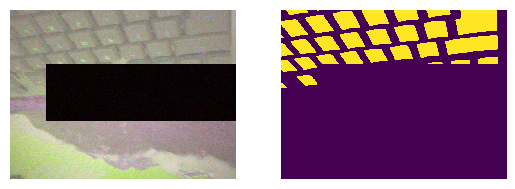

In [33]:
img, mask = train_dataset[random.randint(0, len(train_dataset) - 1)]
imshow(img, mask)
print(img.shape)
imshow(model(img.cpu().unsqueeze(0)).detach().numpy()[0][0])

In [61]:
img.size()

torch.Size([3, 480, 640])

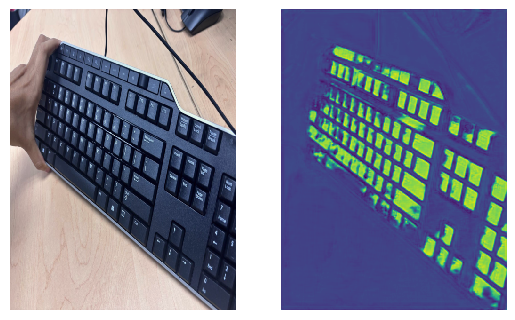

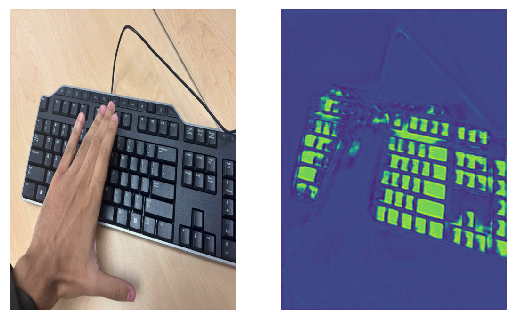

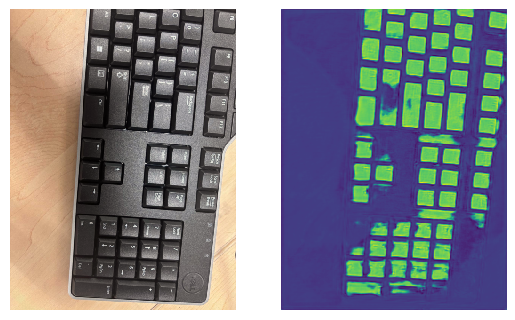

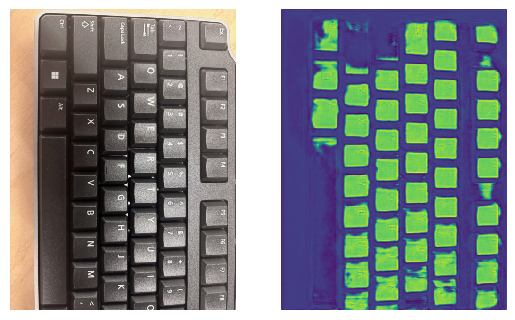

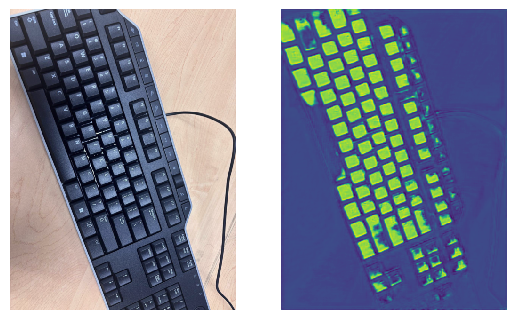

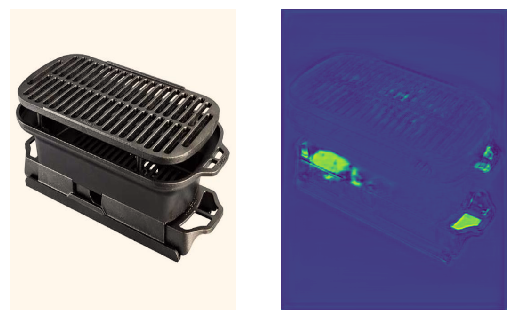

In [31]:
from torchvision.transforms import v2 as transforms

transform = transforms.Compose([
    transforms.ToImage(),
    transforms.Resize((640, 480)),
    transforms.ToDtype(torch.float32, scale=True),
    transforms.Normalize(mean, std),
])

for i in range(6):
    img = Image.open(f"assets/test/test{i}.jpeg")
    img = transform(img)

    imshow(img, model(img.unsqueeze(0)).detach()[0][0])